In [2]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import svm_classifier
import debias
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [3]:
def tsne_by_gender(vecs, labels, title):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)

  names = ["class 1", "class 2"]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b'
  for i, c, label in zip(range(10), colors, names):
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c, label=label, alpha = 0.2)
  plt.legend()
  plt.title(title)
  plt.show()
  return vecs_2d

### Data loading & processing

In [4]:
def load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors):
    
    group1 = model.similar_by_vector(gender_vector, topn = 3000, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = 3000, restrict_vocab=None)
    
    return group1, group2

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)
    return vecs


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

In [17]:
model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")
model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")
#gender_direction = model_gendered["man"] - model_gendered["woman"]
gender_direction = model_gendered["he"] - model_gendered["she"]
gender_direction = model_gendered["he"] + model_gendered["man"] + model_gendered["boy"] + model_gendered["him"] - (model_gendered["she"] + model_gendered["woman"] + model_gendered["girl"] + model_gendered["her"])

masc_words_and_scores, fem_words_and_scores = project_on_gender_subspaces(gender_direction, model)
masc_words, masc_scores = list(zip(*masc_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))

masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)

print(masc_words[:10])
print(masc_words[-10:])
print("-------------------------")
print(fem_words[:10])
print(fem_words[-10:])

('journeyman', 'elder_statesman', 'fellow_countryman', 'journeymen', 'cult_hero', 'wizard', 'knucklehead', 'prodigal_son', 'guys', 'buddy')
('outstretched', 'shakeup', 'pranks', 'silenced', 'shiners', 'charlatans', 'slack', 'linking', 'galloping', 'disrespecting')
-------------------------
('alumna', 'comedienne', 'beautician', 'femininity', 'chanteuse', 'petite', 'songstress', 'girlish', 'saleswoman', 'homemaker')
('homosexual_couples', 'skier', 'upstairs_bedroom', 'educational', 'exhumed', 'masala', 'repertory', 'respondents', 'evening_newscasts', 'bookkeeping')


### Perform train-dev-test split

In [6]:
X = np.concatenate((masc_vecs, fem_vecs), axis = 0)
y_masc = np.zeros(masc_vecs.shape[0], dtype = int)
y_fem = np.ones(fem_vecs.shape[0], dtype = int)
y = np.concatenate((y_masc, y_fem))
X_train_dev, X_test, y_train_dev, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 2520; Dev size: 1080; Test size: 2400


### Debias

In [7]:
classifier_class = svm_classifier.SVMClassifier
num_classifiers = 10
input_dim = 300
is_autoregressive = True
min_accuracy = 0.52
add_noise = False
random_projection = False

P = debias.get_debiasing_projection(classifier_class, num_classifiers, input_dim, 
                                    is_autoregressive, min_accuracy, X_train, Y_train,
                                    X_dev, Y_dev, add_noise, random_projection)

Iteration 0, Accuracy: 1.0
Iteration 1, Accuracy: 0.887962962962963
Iteration 2, Accuracy: 0.8240740740740741
Iteration 3, Accuracy: 0.774074074074074
Iteration 4, Accuracy: 0.7111111111111111
Iteration 5, Accuracy: 0.6444444444444445
Iteration 6, Accuracy: 0.6037037037037037
Iteration 7, Accuracy: 0.587037037037037
Iteration 8, Accuracy: 0.5324074074074074
Iteration 9, Accuracy: 0.5203703703703704


### Test the quality of the debiasing.

#### Perform t-sne

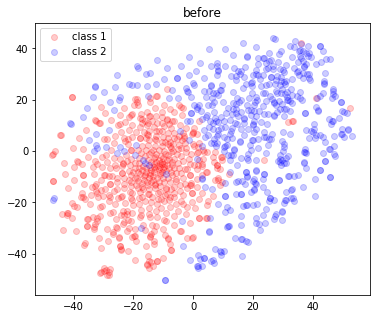

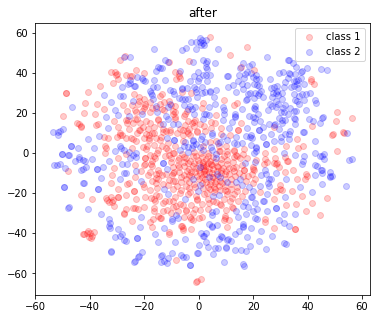

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

Purity in original space: 0.8226155553554912
Purity after debiasing projection: 0.4445532188902586


In [8]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score


tsne_by_gender(X_dev, Y_dev, title = "before")
X_dev_cleaned = X_dev.dot(P)
X_test_cleaned = X_test.dot(P)
X_trained_cleaned = X_train.dot(P)
tsne_projection = tsne_by_gender(X_dev_cleaned, Y_dev, title = "after")

NUM_CLUSTERS = 100

purity_original = perform_purity_test(X_dev, k = NUM_CLUSTERS, labels_true = Y_dev)
purity_after = perform_purity_test(X_dev_cleaned, k = NUM_CLUSTERS, labels_true = Y_dev)
print("Purity in original space: {}".format(purity_original))
print("Purity after debiasing projection: {}".format(purity_after))

#### Train a nonlinear classifier for gender prediction.

In [9]:
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")
#nonlinear_clf = SGDClassifier(loss = "modified_huber", verbose = 0, max_iter = 5000, fit_intercept = True, class_weight = "balanced", penalty = "l2")
print("Before:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

print("After:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

Before:


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9990740740740741
After:


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5935185185185186


#### project on the gender direction

In [10]:
bias_after = ((X_dev_cleaned/(np.linalg.norm(X_dev_cleaned))).dot(gender_direction/np.linalg.norm(gender_direction)))
np.mean(bias_after)

-0.0004667291233238539

#### calculate the similarity matrix before and after

In [66]:

def get_similarity_matrix(vecs: np.ndarray):

  vecs_normalized = vecs / np.linalg.norm(vecs, axis = 1, keepdims = True)
  distances = vecs_normalized.dot(vecs_normalized.T)
  minx = -1 
  maxx = 1
  distances = (distances - minx) / (maxx-minx)
  #distances = sklearn.metrics.pairwise_distances(vecs_normalized, vecs_normalized, metric="cosine")
  
  return distances

def plot_similarity(similarity_before, similarity_after):

    idx = similarity_before > 0.5 # we are only interested in the relatively close words

    similarity_before = similarity_before[idx]
    similarity_after = similarity_after[idx]
    
    chosen = np.random.rand(len(similarity_after)) < 0.01
    before = similarity_before[chosen]
    after = similarity_after[chosen]
    print(len(before), len(after))
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("similarity before")
    plt.ylabel("similarity after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))
    
def plot_similarity_change_vs_original_bias(bias_before, similarity_before, similarity_after):
    print(bias_before.shape, similarity_before.shape)
    K = 3
    most_similar_idx_before = similarity_before.argsort(axis = 1)[-K:][::-1].T
    most_similar_idx_after = similarity_after.argsort(axis = 1)[-K:][::-1].T

    data = []
    
    for i, (bias, sim_before, sim_after) in enumerate(tqdm.tqdm(zip(bias_before, similarity_before, similarity_after), ascii = True, total = len(bias_before))):
        
        idx_before = set(most_similar_idx_before[i].tolist())
        idx_after = set(most_similar_idx_after[i].tolist())
        intersection = idx_before.intersection(idx_after)
        data.append((bias, len(intersection)))
    
    print(np.mean(data))
    
    plt.xlabel("bias before")
    plt.ylabel("change in similarity")
    biases, sims = zip(*data)
    print(biases[:10], len(biases), type(biases))
    print(sims[:10], len(sims), type(sims))
    
    plt.plot(biases, sims, linestyle="None", marker = "*", alpha = 0.1)
    plt.show()

(4861,) (4861, 4861)
194039 194039


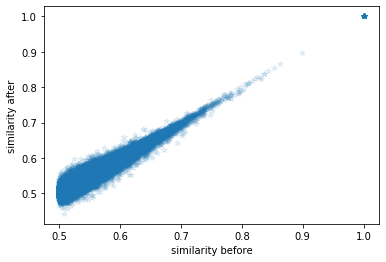

Correlation: 0.9641554361443331
(4861,) (4861, 4861)


100%|##########| 4861/4861 [00:00<00:00, 452615.37it/s]

0.00249063131226111
(0.001600232, 0.021759216, 0.03308835, 0.08523895, 0.030511849, 0.045924447, 0.0010419488, 0.042140737, 0.06758008, 0.08517872) 4861 <class 'tuple'>
(3, 0, 0, 1, 0, 0, 0, 0, 0, 0) 4861 <class 'tuple'>


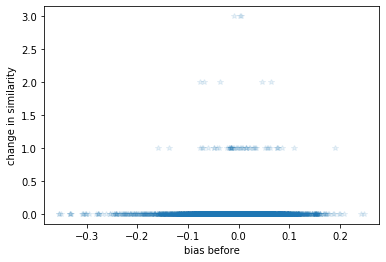

In [67]:
prop = 0.1
idx = np.random.rand(vecs.shape[0]) < prop
vecs_sample = vecs[idx]
vecs_sample_cleaned = vecs_sample.dot(P)

similarity_before = get_similarity_matrix(vecs_sample)
similarity_after = get_similarity_matrix(vecs_sample_cleaned)
diffs = abs(similarity_before - similarity_after)


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
sample_normalized = vecs_sample/np.linalg.norm(vecs_sample, axis = 1, keepdims = True)
sample_cleaned_normalized = vecs_sample_cleaned/np.linalg.norm(vecs_sample_cleaned, axis = 1, keepdims = True)

bias_before = sample_normalized.dot(gender_unit_vec)
bias_after = sample_cleaned_normalized.dot(gender_unit_vec)
print(bias_before.shape, diffs.shape)

plot_similarity(similarity_before.reshape(-1), similarity_after.reshape(-1))
plot_similarity_change_vs_original_bias(bias_before, similarity_before, similarity_after)

In [ ]:
all_cleaned = vecs.dot(P)
save_in_word2vec_format(all_cleaned, words, "../data/embeddings/vecs.cleaned.txt")

36555it [00:09, 4032.68it/s]

In [21]:
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.cleaned.txt")
print(model_cleaned)

In [65]:
w = "koala"
topn = 10

for w_sim in model.most_similar(w, topn = topn):
    print(w_sim)
print("--------------------------------")
for w_sim in model_cleaned.most_similar(w, topn = topn):
    print(w_sim)
    
for w in ["home", "kitchen", "child", "love", "kindness", "gentleness", "passive", "submissive"]:
    print(model.similarity("homemaker", w), model_cleaned.similarity("homemaker", w)) 

('koalas', 0.7420616149902344)
('kangaroos', 0.5646288394927979)
('possums', 0.5404679775238037)
('orangutan', 0.5243529081344604)
('toad', 0.520484447479248)
('croc', 0.5155874490737915)
('panda', 0.5128776431083679)
('possum', 0.5050904750823975)
('orangutans', 0.49788570404052734)
('kangaroo', 0.4943212568759918)
--------------------------------
('koalas', 0.7292592525482178)
('kangaroos', 0.5477023124694824)
('possums', 0.5230434536933899)
('toad', 0.5184125900268555)
('croc', 0.5116813778877258)
('possum', 0.5112431049346924)
('orangutan', 0.507324755191803)
('kangaroo', 0.5001143217086792)
('panda', 0.48874330520629883)
('lizard', 0.4723452627658844)
0.23504066 0.255781
0.28370774 0.26410466
0.22969776 0.17141005
0.15453398 0.1568206
0.15851077 0.13972019
0.16485238 0.15254821
0.1668799 0.17283589
0.22039527 0.16783103
